## Определение перспективного тарифа для телеком-компании

### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана
### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок
### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение
### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя
### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [422]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math

from scipy import stats as st

%matplotlib inline

## Изучение данных из файлов

### users

In [423]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [424]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [425]:
df_users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


df_users - нет пропущенных значений(churn_date - по описанию, если пропущено, то тариф еще действовал). По датасету у нас 500 записей

### calls

In [426]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [427]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [428]:
df_calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


df_calls - 202607 записей, пропусков нет

### messages

In [429]:
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [430]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


df_messages - 123036 записей, пропусков нет

### internet

In [431]:
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [432]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [433]:
df_internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


df_internet - 149396 записей без пропусков, есть столбец на удаление

### tariffs

In [434]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [435]:
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [436]:
df_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

Для будущего удобства переименовали tariff_name в tariff

df_tariffs - 2 записи, пропусков нет, содержит описание тарифов

In [437]:
df_users.duplicated().sum(), \
df_calls.duplicated().sum(), \
df_messages.duplicated().sum(), \
df_internet.duplicated().sum()

(0, 0, 0, 0)

### Вывод

- У нас всего 5 таблиц данных, для всех общая фича user_id
- Для users это данные пользователя, таблицы calls, messages, internet содержат данные пользователей об использовании тарифа
- tariffs содержит данные по тарифу
- Пропущенных значений нет
- Дубликатов нет
- Аномалий нет

## Подготовка данных

### Оптимизация памяти

In [438]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :", start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            try:
                result = (props[col] - asint)
                result = result.sum()
                if result > -0.01 and result < 0.01:
                    IsInt = True

                # Make Integer/unsigned Integer datatypes
                if IsInt:
                    if mn >= 0:
                        if mx < 255:
                            props[col] = props[col].astype(np.uint8)
                        elif mx < 65535:
                            props[col] = props[col].astype(np.uint16)
                        elif mx < 4294967295:
                            props[col] = props[col].astype(np.uint32)
                        else:
                            props[col] = props[col].astype(np.uint64)
                    else:
                        if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                            props[col] = props[col].astype(np.int8)
                        elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                            props[col] = props[col].astype(np.int16)
                        elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                            props[col] = props[col].astype(np.int32)
                        elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                            props[col] = props[col].astype(np.int64)    

                # Make float datatypes 32 bit
                else:
                    props[col] = props[col].astype(np.float32)

                # Print new column type
                print("dtype after: ",props[col].dtype)
                print("******************************")
            except TypeError:
                pass
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df_users, NAlist = reduce_mem_usage(df_users)
df_calls, NAlist = reduce_mem_usage(df_calls)
df_messages, NAlist = reduce_mem_usage(df_messages)
df_internet, NAlist = reduce_mem_usage(df_internet)
df_tariffs, NAlist = reduce_mem_usage(df_tariffs)

Memory usage of properties dataframe is : 0.0306396484375  MB
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  age
dtype before:  int64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.024440765380859375  MB
This is  79.76842629482071 % of the initial size
Memory usage of properties dataframe is : 6.183197021484375  MB
******************************
Column:  duration
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint16
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  4.250986099243164  MB
This is  68.75061694577293 % of the initial size
Memory usage of properties dataframe is : 2.816192626953125  MB
******************************
Column:  user_id
dtype before:  int64
dty

### df_users

In [439]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


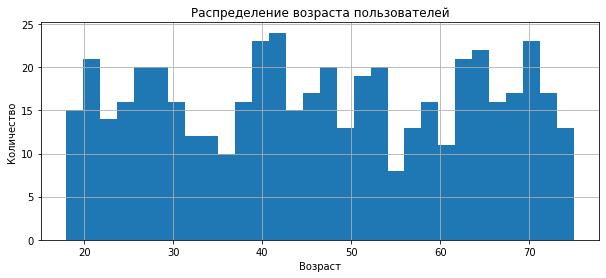

In [440]:
df_users['age'].hist(bins=30, figsize=(10, 4))
plt.title('Распределение возраста пользователей')
plt.ylabel('Количество')
plt.xlabel('Возраст')
plt.show()

In [441]:
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Посмотрели что нет повторов

In [442]:
df_users['tariff'].unique()

array(['ultra', 'smart'], dtype=object)

In [443]:
df_users[~df_users['churn_date'].isna()].sample()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra


Посмотрели что есть записи с окончанием даты использования тарифа

### df_calls

In [444]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


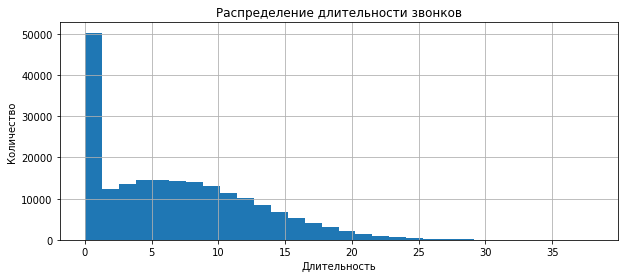

In [445]:
df_calls['duration'].hist(bins=30, figsize=(10, 4))
plt.title('Распределение длительности звонков')
plt.ylabel('Количество')
plt.xlabel('Длительность')
plt.show()

### df_messages

In [446]:
df_messages.tail(5)

,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


### df_internet

In [447]:
# len 149396, unnamed - 149396
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.949997,2018-11-25,1000
1,1,1000_1,1052.810059,2018-09-07,1000
2,2,1000_2,1197.260010,2018-06-25,1000
3,3,1000_3,550.270020,2018-08-22,1000
4,4,1000_4,302.559998,2018-09-24,1000


In [448]:
df_internet = df_internet.drop(['Unnamed: 0'], axis=1)
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.949997,2018-11-25,1000
1,1000_1,1052.810059,2018-09-07,1000
2,1000_2,1197.260010,2018-06-25,1000
3,1000_3,550.270020,2018-08-22,1000
4,1000_4,302.559998,2018-09-24,1000


### df_tariffs

In [449]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переведем mb_per_month_included в гигабайты и переименуем столбец

In [450]:
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'].apply(lambda x: x / 1024)

In [451]:
df_tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [452]:
df_tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


### Объединим данные таблиц df_users, df_calls

Сделаем правое присоединение, так отсечем пользователей, которые не делали звонков

In [453]:
df_user_calls = df_users.merge(df_calls, how='right')
df_user_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,duration
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,0.00
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,0.00
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,2.85
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,13.80
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,5.18


In [454]:
df_user_tariff = df_users[['user_id', 'tariff']].merge(df_tariffs)

In [455]:
df_user_tariff.sample()

,user_id,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
458,1439,smart,50,15.0,500,550,200,3,3


### Количество сделанных звонков и израсходованных минут разговора по месяцам по пользователям

In [456]:
df_user_calls['call_date_month'] = df_user_calls['call_date'].apply(lambda x: x[:7])

In [457]:
df_user_calls.groupby(['call_date_month', 'user_id']).agg('count')['duration']

call_date_month  user_id
2018-01          1005        15
                 1032        61
                 1045         1
                 1055        64
                 1071        24
                           ... 
2018-12          1494        62
                 1495       155
                 1496        80
                 1497        71
                 1499        69
Name: duration, Length: 3174, dtype: int64

Получли данные по количеству сделанных звонков по месяцам и пользователю

In [458]:
df_user_calls.groupby(['call_date_month', 'user_id']).agg('sum')['duration']

call_date_month  user_id
2018-01          1005        90.930000
                 1032       359.160004
                 1045         8.330000
                 1055       527.950012
                 1071       183.960007
                               ...    
2018-12          1494       388.290009
                 1495       970.940002
                 1496       483.910004
                 1497       515.330017
                 1499       465.160004
Name: duration, Length: 3174, dtype: float32

Получли данные по продолжительности звонков по месяцам и пользователю

### Объединим данные таблиц df_users, df_messages

In [459]:
df_user_messages = df_users.merge(df_messages, how='right') # how='right' - отсекли записи, по которым не было сообщений
df_user_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05


### Количество отправленных сообщений по месяцам по пользователям

In [460]:
df_user_messages['message_date_month'] = df_user_messages['message_date'].apply(lambda x: x[:7])
df_user_messages.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,message_date,message_date_month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-06-27,2018-06
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-10-08,2018-10
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-08-04,2018-08
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-06-16,2018-06
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-05,2018-12


In [461]:
df_user_messages.groupby(['message_date_month', 'user_id']).agg('count')['id']

message_date_month  user_id
2018-01             1005        7
                    1032       38
                    1045        5
                    1055       30
                    1071       16
                               ..
2018-12             1493       78
                    1495       84
                    1496       51
                    1497       17
                    1499       66
Name: id, Length: 2717, dtype: int64

Получли данные по количеству сообщений по месяцам и пользователю

### Объединим данные таблиц df_users, df_internet

In [462]:
df_user_internet = df_users.merge(df_internet, how='right') # how='right' - отсекли пользователей, которые не пользовались интернетом
df_user_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,112.949997,2018-11-25
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1052.810059,2018-09-07
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1197.260010,2018-06-25
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,550.270020,2018-08-22
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,302.559998,2018-09-24


### Объем израсходованного интернет-трафика по месяцам по пользователям

In [463]:
df_user_internet['session_date_month'] = df_user_internet['session_date'].apply(lambda x: x[:7])
df_user_internet.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,mb_used,session_date,session_date_month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,112.949997,2018-11-25,2018-11
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,1052.810059,2018-09-07,2018-09
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,1197.260010,2018-06-25,2018-06
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,550.270020,2018-08-22,2018-08
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,302.559998,2018-09-24,2018-09


In [464]:
df_user_internet.groupby(['session_date_month', 'user_id']).agg('sum')['mb_used']

session_date_month  user_id
2018-01             1005        2727.969971
                    1032       24127.689453
                    1045        2346.709961
                    1055       17090.880859
                    1071       15604.339844
                                   ...     
2018-12             1494       17621.210938
                    1495       23426.759766
                    1496       20736.150391
                    1497       19918.599609
                    1499       13055.580078
Name: mb_used, Length: 3203, dtype: float32

Получли данные по объему траффика(мб) по месяцам и пользователю

### Помесячная выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)

In [465]:
df_internet.sample()

,id,mb_used,session_date,user_id
5844,1017_284,0.0,2018-08-13,1017


In [466]:
df_internet.columns = ['id', 'gb_used', 'session_date', 'user_id']

Приведем к единому типу данные

In [467]:
df_internet['gb_used'] = df_internet['gb_used'] / 1024

In [468]:
df_calls['call_date_month'] = df_calls['call_date'].apply(lambda x: x[:7])
df_messages['message_date_month'] = df_messages['message_date'].apply(lambda x: x[:7])
df_internet['session_date_month'] = df_internet['session_date'].apply(lambda x: x[:7])

In [469]:
total = df_users.merge(df_calls, how='outer')\
    .merge(df_messages, how='outer')\
    .merge(df_internet, how='outer')\
    .merge(df_tariffs, on='tariff')
total.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,id,call_date,...,gb_used,session_date,session_date_month,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_0,2018-07-25,...,0.110303,2018-11-25,2018-11,1000,30.0,3000,1950,150,1,1
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_1,2018-08-17,...,1.028135,2018-09-07,2018-09,1000,30.0,3000,1950,150,1,1
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_2,2018-06-11,...,1.169199,2018-06-25,2018-06,1000,30.0,3000,1950,150,1,1
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_3,2018-09-21,...,0.537373,2018-08-22,2018-08,1000,30.0,3000,1950,150,1,1
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000_4,2018-12-15,...,0.295469,2018-09-24,2018-09,1000,30.0,3000,1950,150,1,1


- Исходя из задачи, если время звонка меньше минуты, то запишем 1 минута, если больше минуты, то поделим на 60, если остатка от деления нет, то запишем результат деления, если остаток есть, то результат деления +1
- Для сообщений нет отдельного подсчета, сколько в сумме есть за месяц - столько и считаем
- Для подсчета потраченного трафика будем суммировать объемы

In [470]:
def change_duration_call(duration):
    if duration:
        if duration == 0:
            return 0
        elif duration > 0 and duration < 1:
            return 1
        elif duration >= 1:
            if (duration * 60) % 60:
                return math.ceil(duration)
            return duration
    return duration

In [471]:
# total['duration_new'] = total['duration'].apply(change_duration_call)

In [472]:
total['duration'] = np.ceil(total['duration'])

In [473]:
total['duration'][:5]

0     0.0
1     0.0
2     3.0
3    14.0
4     6.0
Name: duration, dtype: float32

In [474]:
users = list(total['user_id'].unique())

In [475]:
[1473, 1091, 1128, 1231, 1328, 1489, 1106, 1371]

[1473, 1091, 1128, 1231, 1328, 1489, 1106, 1371]

In [476]:
dfs_calls = []
dfs_msgs = []
dfs_intt = []
for i in users:
#     dfs_calls.append(total[total['user_id'] == i]\
#                 .groupby(['call_date_month', 'user_id'])\
#                 .agg('count')['duration'].reset_index())
    dfs_calls.append(total[total['user_id'] == i]\
                .groupby(['call_date_month', 'user_id'])\
                .agg('sum')['duration'].reset_index())
    dfs_msgs.append(total[total['user_id'] == i]\
                .groupby(['message_date_month', 'user_id'])\
                .agg('count')['id'].reset_index())
    dfs_intt.append(total[total['user_id'] == i]\
                .groupby(['session_date_month', 'user_id'])\
                .agg('sum')['gb_used'].reset_index())
    
calls = pd.concat(dfs_calls)
# calls['user_id'] = calls['user_id'].apply(lambda x: math.ceil(x))
calls['user_id'] = np.ceil(calls['user_id'])
calls.columns = ['date_month', 'user_id', 'calls_duration']
msgs = pd.concat(dfs_msgs)
msgs.columns = ['date_month', 'user_id', 'msg_counts']
# msgs['user_id'] = msgs['user_id'].apply(lambda x: math.ceil(x))
msgs['user_id'] = np.ceil(msgs['user_id'])
intt = pd.concat(dfs_intt)
intt.columns = ['date_month', 'user_id', 'gb_used']

In [477]:
new_df = calls.merge(msgs, how='outer').merge(intt, how='outer')

In [478]:
df_final = new_df.merge(df_user_tariff, on='user_id').fillna(0)
df_final.sample(5)

,date_month,user_id,calls_duration,msg_counts,gb_used,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
552,2018-04,1330.0,485.0,78.0,32.338097,ultra,1000,30.0,3000,1950,150,1,1
1830,2018-03,1188.0,46.0,3.0,1.727109,smart,50,15.0,500,550,200,3,3
461,2018-12,1276.0,361.0,29.0,25.047607,ultra,1000,30.0,3000,1950,150,1,1
2316,2018-03,1299.0,714.0,38.0,21.136797,smart,50,15.0,500,550,200,3,3
2080,2018-08,1244.0,515.0,72.0,19.398741,smart,50,15.0,500,550,200,3,3


In [479]:
lost_users = list(set(list(total['user_id'].unique())) - set(list(df_final.user_id.unique())))

In [480]:
df_final.user_id.nunique()

492

In [481]:
lost_col = df_users.query("user_id in @lost_users")[['user_id', 'tariff']].merge(df_tariffs, how='outer')
lost_col['date_month'] = '2018-13'

In [482]:
df_final = df_final.append(lost_col, ignore_index=True)

In [483]:
df_final.user_id.nunique()

500

In [484]:
def total_month_fee_count(x):
    x['total_fee'] = 0
    for index, row in x.iterrows():
        total_fee = 0
        
        # сколько было звонков сделано
        calls = row['calls_duration'] - row['minutes_included']
        #print(f'calls {calls}')
        
        # сколько было сообщений отправлено
        msgs = row['msg_counts'] - row['messages_included']
        #print(f'msgs {msgs}')
            
        # сколько гигабайт
        intt = row['gb_used'] - row['gb_per_month_included']
        #print(f'intt {intt}')
    
        if calls > 0:
            total_fee += calls * row['rub_per_minute']
            #print(f'total_fee {total_fee}')
        if msgs > 0:
            total_fee += msgs * row['rub_per_message']
            #print(f'total_fee {total_fee}')
        if intt > 0:
            total_fee += math.ceil(intt) * row['rub_per_gb']
            #print(f'total_fee {total_fee}')
        
        total_fee += row['rub_monthly_fee']
        #print(f'total_fee {total_fee}')
        x.loc[index, 'total_fee'] = total_fee
        #print(index)        
        #print('*'*50)

In [485]:
total_month_fee_count(df_final)

In [486]:
df_final.sample(5)

,calls_duration,date_month,gb_per_month_included,gb_used,messages_included,minutes_included,msg_counts,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,total_fee
1424,330.0,2018-12,15.0,10.026953,50,500,0.0,550,200,3,3,smart,1107.0,550.0
231,633.0,2018-09,30.0,22.147676,1000,3000,0.0,1950,150,1,1,ultra,1143.0,1950.0
2441,754.0,2018-12,15.0,19.749004,50,500,96.0,550,200,3,3,smart,1324.0,2450.0
3103,331.0,2018-08,15.0,18.770821,50,500,40.0,550,200,3,3,smart,1482.0,1350.0
374,175.0,2018-10,30.0,8.596240,1000,3000,21.0,1950,150,1,1,ultra,1226.0,1950.0


In [487]:
df_final['total_fee'].describe()

count    3184.000000
mean     1374.613693
std       778.829394
min       550.000000
25%       550.000000
50%      1350.000000
75%      1950.000000
max      6770.000000
Name: total_fee, dtype: float64

## Анализ данных

### Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитайте среднее количество, дисперсию и стандартное отклонение

In [488]:
df_final\
    .groupby([
        'date_month', 
        'tariff',
])\
    .agg('mean')[
    ['calls_duration', 'msg_counts', 'gb_used']
]

calls_duration  msg_counts    gb_used
date_month tariff                                       
2018-01    smart       203.852936   15.852941   7.044701
           ultra       428.111115   29.000000  12.299184
2018-02    smart       298.689667   20.931034   9.623157
           ultra       297.125000   16.916667   9.661793
2018-03    smart       390.051941   27.493506  12.731711
           ultra       489.648651   24.189189  14.919638
2018-04    smart       367.133942   27.303571  11.685924
           ultra       466.500000   25.629630  15.184475
2018-05    smart       387.361694   29.751773  13.715810
           ultra       534.250000   30.484375  17.520979
2018-06    smart       395.640259   28.945122  13.711230
           ultra       497.469147   29.679012  16.612602
2018-07    smart       408.353241   29.741294  13.530246
           ultra       564.397705   34.465909  17.566935
2018-08    smart       423.269226   29.337607  14.511579
           ultra       530.611633   34.572816  16.969887
2018-09    smart       430.266418   29.386100  14.139348
           ultra       558.882874   38.126126  16.987579
2018-10    smart       427.590454   29.883959  14.535438
           ultra       581.728821   43.042373  17.750061
2018-11    smart       436.647614   29.847619  14.834405
           ultra       562.364319   40.682171  17.417973
2018-12    smart       479.985107   31.339286  15.928720
           ultra       614.925354   44.313433  19.101387
2018-13    smart              NaN         NaN        NaN
           ultra              NaN         NaN        NaN

Видим что пользователи тарифа ultra вне зависимости от месяца в среднем больше говорят, в среднем отправляют больше сообщений и в среднем используют больше трафика, чем пользователи тарифа smart

In [489]:
df_final\
    .groupby([
        'date_month', 
        'tariff',
])\
    .agg('var')[
    ['calls_duration', 'msg_counts', 'gb_used']
]

calls_duration   msg_counts    gb_used
date_month tariff                                        
2018-01    smart     23787.341797   209.583779  40.237705
           ultra     72769.359375   695.250000  40.314194
2018-02    smart     36412.289062   378.381125  36.039902
           ultra     87919.679688   459.210145  97.539642
2018-03    smart     36823.156250   516.016405  34.316383
           ultra    111384.898438   664.657658  82.153542
2018-04    smart     34778.207031   467.997104  30.202419
           ultra     68974.406250   760.841370  63.819229
2018-05    smart     34820.062500   543.602229  33.982052
           ultra     74881.015625   991.999752  79.638245
2018-06    smart     30742.917969   513.769976  33.360287
           ultra     86019.648438  1007.695679  84.158340
2018-07    smart     32250.269531   570.232736  29.666920
           ultra     86952.585938  1060.987330  78.090614
2018-08    smart     34177.269531   558.662356  30.555887
           ultra     91169.554688  1135.443175  95.293648
2018-09    smart     32950.531250   528.811589  27.416590
           ultra     98597.906250  1139.438493  84.061607
2018-10    smart     34889.531250   578.746762  31.167349
           ultra     97140.335938  1457.835796  89.443581
2018-11    smart     31100.611328   553.040400  28.005684
           ultra     88449.625000  1302.374758  90.201035
2018-12    smart     39131.449219   597.812900  30.050123
           ultra    107981.031250  1375.073954  98.068825
2018-13    smart              NaN          NaN        NaN
           ultra              NaN          NaN        NaN

Дисперсия или мера разброса значений достаточно высока

In [490]:
df_final\
    .groupby([
        'date_month', 
        'tariff',
])\
    .agg('std')[
    ['calls_duration', 'msg_counts', 'gb_used']
]

calls_duration  msg_counts   gb_used
date_month tariff                                      
2018-01    smart       154.231455   14.477009  6.343320
           ultra       269.757964   26.367594  6.349346
2018-02    smart       190.820044   19.452021  6.003324
           ultra       296.512529   21.429189  9.876216
2018-03    smart       191.893607   22.715994  5.858019
           ultra       333.743762   25.780955  9.063859
2018-04    smart       186.489161   21.633241  5.495673
           ultra       262.629789   27.583353  7.988694
2018-05    smart       186.601346   23.315279  5.829413
           ultra       273.643958   31.496028  8.924026
2018-06    smart       175.336585   22.666495  5.775836
           ultra       293.291064   31.744223  9.173786
2018-07    smart       179.583600   23.879546  5.446735
           ultra       294.877239   32.572800  8.836889
2018-08    smart       184.870954   23.636039  5.527738
           ultra       301.942966   33.696338  9.761847
2018-09    smart       181.522812   22.995904  5.236085
           ultra       314.003035   33.755570  9.168512
2018-10    smart       186.787396   24.057156  5.582773
           ultra       311.673444   38.181616  9.457462
2018-11    smart       176.353654   23.516811  5.292040
           ultra       297.404817   36.088430  9.497423
2018-12    smart       197.816706   24.450213  5.481799
           ultra       328.604673   37.081990  9.902971
2018-13    smart              NaN         NaN       NaN
           ultra              NaN         NaN       NaN

Стандартное отклонение также высоко, например для января месяца среденяя продолжительность звонков тарифа smart - 193.04, дисперсия - 433.13, а стандартное отклонение - 20.81.

### Постройте гистограммы. Опишите распределения.

In [491]:
df_final[df_final['tariff'] == 'smart']\
    .groupby([
        'date_month', 
])\
    .agg('mean')[
    ['calls_duration', 'msg_counts', 'gb_used']
].reset_index()

,date_month,calls_duration,msg_counts,gb_used
0,2018-01,203.852936,15.852941,7.044701
1,2018-02,298.689667,20.931034,9.623157
2,2018-03,390.051941,27.493506,12.731711
3,2018-04,367.133942,27.303571,11.685924
4,2018-05,387.361694,29.751773,13.715810
5,2018-06,395.640259,28.945122,13.711230
6,2018-07,408.353241,29.741294,13.530246
7,2018-08,423.269226,29.337607,14.511579
8,2018-09,430.266418,29.386100,14.139348
9,2018-10,427.590454,29.883959,14.535438


In [492]:
smart_hist = df_final[df_final['tariff'] == 'smart']\
    .groupby([
        'date_month', 
])\
    .agg('mean')[
    ['calls_duration', 'msg_counts', 'gb_used']
].reset_index()

ultra_hist = df_final[df_final['tariff'] == 'ultra']\
    .groupby([
        'date_month', 
])\
    .agg('mean')[
    ['calls_duration', 'msg_counts', 'gb_used']
].reset_index()

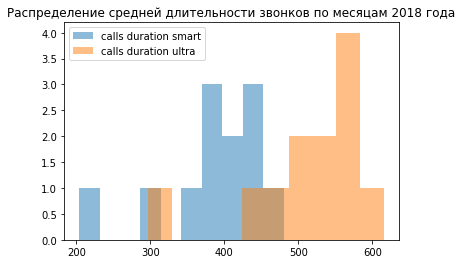

In [493]:
plt.hist(smart_hist['calls_duration'], alpha=0.5, label='calls duration smart')
plt.hist(ultra_hist['calls_duration'], alpha=0.5, label='calls duration ultra')
plt.legend(loc='upper left')
plt.title('Распределение средней длительности звонков по месяцам 2018 года')
plt.show()

Получается, что пользователи тарифа smart чаще делают звонки средней длительностью 6,5 часов или 7,5 часов, а пользователи тарифа ultra чаще разговаривают по 9,33 часов в месяц.

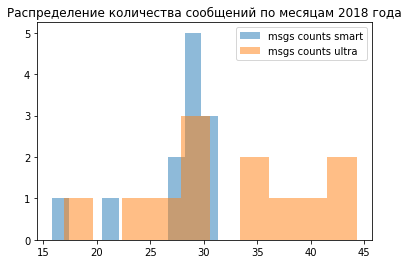

In [494]:
plt.hist(smart_hist['msg_counts'], alpha=0.5, label='msgs counts smart')
plt.hist(ultra_hist['msg_counts'], alpha=0.5, label='msgs counts ultra')
plt.legend(loc='upper right')
plt.title('Распределение количества сообщений по месяцам 2018 года')
plt.show()

Пользователи обоих тарифов чаще всего отправляют в среднем около 30 сообщений в месяц, при этом пользователи тарифа smart делают это 5 месяцев в году, а пользователи тарифа ultra всего 3.

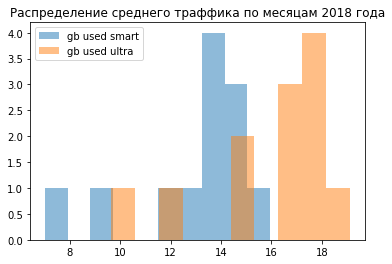

In [495]:
plt.hist(smart_hist['gb_used'], alpha=0.5, label='gb used smart')
plt.hist(ultra_hist['gb_used'], alpha=0.5, label='gb used ultra')
plt.legend(loc='upper left')
plt.title('Распределение среднего траффика по месяцам 2018 года')
plt.show()

Пользователи тарифа smart в среднем чаще используют около 14 Гб траффика, против 18 Гб пользователей тарифа ultra.

## Анализ данных

### Гипотеза 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются

Когда генеральных совокупностей две, бывает нужно сопоставить их средние.

Чтобы понять, различаются ли средние абонентские платы по двум тарифам, недостаточно просто сравнить числа средних. Без проведения корректного теста нельзя считать отличия случайными или разницу достаточной, чтобы полагать суммы разными.

In [496]:
df_final[df_final['tariff'] == 'ultra'].agg({'total_fee': 'mean'})

total_fee    2026.096033
dtype: float64

In [497]:
df_final[df_final['tariff'] == 'smart'].agg({'total_fee': 'mean'})

total_fee    1094.236298
dtype: float64

Для примера вывели среднее

In [499]:
df_final[df_final['tariff'] == 'ultra'].sample()

,calls_duration,date_month,gb_per_month_included,gb_used,messages_included,minutes_included,msg_counts,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,total_fee
603,982.0,2018-09,30.0,2.853096,1000,3000,56.0,1950,150,1,1,ultra,1346.0,1950.0


In [500]:
def chech_hypothesis(sample_1, sample_2):
    alpha = 0.05  # критический уровень статистической значимости
    # если p-value окажется меньше него - отвергнем гипотезу
    results = st.ttest_ind(sample_1, sample_2, equal_var=False)

    print('p-значение:', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

In [501]:
ul = df_final[df_final['tariff'] == 'ultra']['total_fee']
sm = df_final[df_final['tariff'] == 'smart']['total_fee']

In [502]:
chech_hypothesis(ul, sm)

p-значение: 0.0
Отвергаем нулевую гипотезу


### Гипотеза 2. Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

In [503]:
moscow_city = df_final.merge(df_users[['user_id', 'city']], how='left')
moscow_city = moscow_city[moscow_city['city'] == 'Москва']
moscow_city.sample()

,calls_duration,date_month,gb_per_month_included,gb_used,messages_included,minutes_included,msg_counts,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,total_fee,city
407,504.0,2018-03,30.0,28.005547,1000,3000,0.0,1950,150,1,1,ultra,1254.0,1950.0,Москва


In [504]:
others_cities = df_final.merge(df_users[['user_id', 'city']], how='left')
others_cities = others_cities[~(others_cities['city'] == 'Москва')]
others_cities.sample()

,calls_duration,date_month,gb_per_month_included,gb_used,messages_included,minutes_included,msg_counts,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,user_id,total_fee,city
1421,352.0,2018-09,15.0,6.424092,50,500,0.0,550,200,3,3,smart,1107.0,550.0,Орёл


In [505]:
sample_moscow = list(pd.pivot_table(moscow_city, 
               values=['total_fee'], index=['user_id'],
               aggfunc={'total_fee': np.mean}).reset_index(drop=True)['total_fee'])
sample_ot_cts = list(pd.pivot_table(others_cities, 
               values=['total_fee'], index=['user_id'],
               aggfunc={'total_fee': np.mean}).reset_index(drop=True)['total_fee'])

In [506]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(sample_moscow, sample_ot_cts, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.6449545383104964
Не получилось отвергнуть нулевую гипотезу


## Вывод

- Мы получили данные траффика, сделанных звонков и израсходованных минут разговора по месяцам по пользователям
- По этим данным мы посчитали сколько тратил каждый пользователь ежемесячно
- Проанализировав гистограммы средних по месяцам мы выяснили сколько чаще общаются, сколько смс посылают и какой объем трафика у пользователей каких тарифов:
    - Получается, что пользователи тарифа smart чаще делают звонки средней длительностью 6,5 часов или 7,5 часов, а пользователи тарифа ultra чаще разговаривают по 9,33 часов в месяц. При этом длительность звонков абонентов тарифа smart в среднем не превышает 8,3 часа, в то время как средняя продолжительность разговора абонентов ultra не ниже 5 часов.
    - Пользователи обоих тарифов чаще всего отправляют в среднем около 30 сообщений в месяц, при этом пользователи тарифа smart делают это 5 месяцев в году, а пользователи тарифа ultra всего 3. Также пользователи тарифа smart в среднем не посылают больше 30 сообщений в месяц, в то время как для тарифа ultra средняя максимальная цифра доходит почти до 45.
    - Пользователи тарифа smart в среднем чаще используют около 14 Гб траффика, против 18 Гб пользователей тарифа ultra. Получается пользователи тарифа smart чаще полностью расходуют свой лимит, не превышая его(это 15Гб), а пользователи тарифа ultra совсем не дотягивают до своего максимума в 30 Гб.
    - Из данных по графикам в целом видно, что пользователи тарифа ultra в среднем не на много больше общаются, чем пользователи более дешевого тарифа smart
- Мы также проверили 2 гипотезы:
    - Выяснили, что при критическом уровне статистической значимости равном 0.05 наша гипотеза о том, что средняя выручка двух тарифов не различается, подтверждается.
    - Не смогли опровергнуть гипотезу о том, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов, так как рассчитанное p-значение: 0.80, а значит пользователи из Москвы действительно в среднем платят одинаково.